<a href="https://colab.research.google.com/github/slimf1/ZZ3-DL/blob/main/08_GAN_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import argparse

import tensorflow.keras as tk


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape,Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout,BatchNormalization
from tensorflow.keras.optimizers import RMSprop

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def plotImages(G,sauve=False, fake=True, nb=16, noise=None, step=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[nb, 100])
        else:
            filename = "./images/mnist_%d.png" % step
        images = G.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], nb)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [taille_image, taille_image])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if sauve:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) =tk.datasets.mnist.load_data()



num_examples = x_train.shape[0] 
num_input = x_train.shape[1]*x_train.shape[2]
num_classes = 10
x_train = x_train.reshape(-1, x_train.shape[1],x_train.shape[2],1).astype(np.float32)/255
x_test = x_test.reshape(-1, x_test.shape[1],x_test.shape[2],1).astype(np.float32)/255




11501568/11490434 [==============================] - 0s 0us/step


In [4]:
numEpochs = 2000000
tailleBatch = 128
dropout = 0.5
nb_filtres = 64
taille_image = 28
latentDim = 100


In [5]:
def discriminant():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)
    D = Sequential()
    depth = nb_filtres
    input_shape = (x_train.shape[1], x_train.shape[2], 1)
    D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    D.add(LeakyReLU(alpha=0.2))
    D.add(Dropout(dropout))

    D.add(Flatten())
    D.add(Dense(1))
    D.add(Activation('sigmoid'))
    D.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return D

In [6]:
#Réseau générateur
def generateur():
    G = Sequential()
    depth = 4*nb_filtres
    dim = 7
    G.add(Dense(dim*dim*depth, input_dim=latentDim))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))
    G.add(Reshape((dim, dim, depth)))
    G.add(Dropout(dropout))

    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    G.add(UpSampling2D())
    G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(Activation('relu'))

    G.add(Conv2DTranspose(1, 5, padding='same'))
    G.add(Activation('sigmoid'))
    G.summary()
    return G

In [7]:
def adversarial():
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    A = Sequential()
    A.add(G)
    A.add(D)
    A.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return A

In [8]:

def myGAN(D,A,G):

    noise_input = None
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
 
    for i in range(numEpochs):
        images_train = x_train[np.random.randint(0,x_train.shape[0], size=tailleBatch), :, :, :]
        noise = np.random.uniform(-1.0, 1.0, size=[tailleBatch, 100])
        images_fake = G.predict(noise)
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*tailleBatch, 1])
        y[tailleBatch:, :] = 0
        d_loss = D.train_on_batch(x, y)

        y = np.ones([tailleBatch, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[tailleBatch, 100])
        a_loss = A.train_on_batch(noise, y)
        log_mesg = "Iter %d [perte D = %f, précision D = %f]/[perte A= %f, précision A= %f]" % (i, d_loss[0], d_loss[1],a_loss[0], a_loss[1])
        print(log_mesg)

        if i % 100 == 0:
            plotImages(G,fake=True)
            plotImages(G,fake=False, sauve=True)

        

Iter 8290 [perte D = 0.657403, précision D = 0.593750]/[perte A= 0.838439, précision A= 0.343750]
Iter 8291 [perte D = 0.667714, précision D = 0.605469]/[perte A= 0.898414, précision A= 0.312500]
Iter 8292 [perte D = 0.640312, précision D = 0.617188]/[perte A= 0.844814, précision A= 0.320312]
Iter 8293 [perte D = 0.613891, précision D = 0.703125]/[perte A= 0.819219, précision A= 0.398438]
Iter 8294 [perte D = 0.641881, précision D = 0.625000]/[perte A= 0.966544, précision A= 0.203125]
Iter 8295 [perte D = 0.662101, précision D = 0.601562]/[perte A= 0.737268, précision A= 0.492188]
Iter 8296 [perte D = 0.641323, précision D = 0.628906]/[perte A= 0.918524, précision A= 0.203125]
Iter 8297 [perte D = 0.625948, précision D = 0.640625]/[perte A= 0.814085, précision A= 0.359375]
Iter 8298 [perte D = 0.626472, précision D = 0.675781]/[perte A= 0.875819, précision A= 0.328125]
Iter 8299 [perte D = 0.655478, précision D = 0.621094]/[perte A= 0.975916, précision A= 0.187500]
Iter 8300 [perte D =

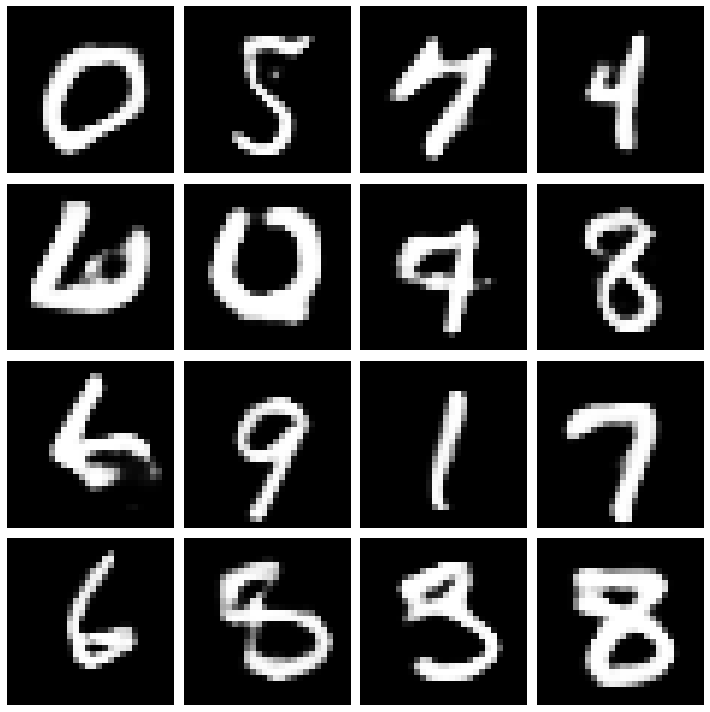

Iter 8301 [perte D = 0.652819, précision D = 0.617188]/[perte A= 0.912472, précision A= 0.250000]
Iter 8302 [perte D = 0.640353, précision D = 0.617188]/[perte A= 0.918617, précision A= 0.203125]
Iter 8303 [perte D = 0.641538, précision D = 0.632812]/[perte A= 0.787955, précision A= 0.382812]
Iter 8304 [perte D = 0.637788, précision D = 0.652344]/[perte A= 0.928232, précision A= 0.250000]
Iter 8305 [perte D = 0.653911, précision D = 0.613281]/[perte A= 0.860389, précision A= 0.289062]
Iter 8306 [perte D = 0.631677, précision D = 0.621094]/[perte A= 0.848429, précision A= 0.320312]
Iter 8307 [perte D = 0.643215, précision D = 0.605469]/[perte A= 0.827966, précision A= 0.367188]
Iter 8308 [perte D = 0.646957, précision D = 0.628906]/[perte A= 0.900806, précision A= 0.273438]
Iter 8309 [perte D = 0.679014, précision D = 0.625000]/[perte A= 0.835332, précision A= 0.328125]
Iter 8310 [perte D = 0.668118, précision D = 0.605469]/[perte A= 0.959160, précision A= 0.210938]
Iter 8311 [perte D =

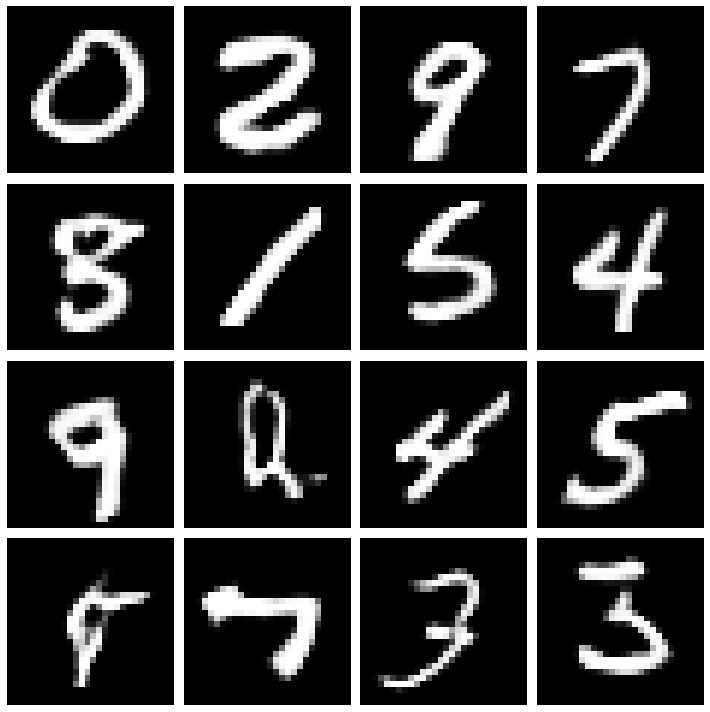

Iter 8401 [perte D = 0.646100, précision D = 0.632812]/[perte A= 0.980858, précision A= 0.218750]
Iter 8402 [perte D = 0.650444, précision D = 0.609375]/[perte A= 0.802333, précision A= 0.375000]
Iter 8403 [perte D = 0.646250, précision D = 0.652344]/[perte A= 0.920465, précision A= 0.304688]
Iter 8404 [perte D = 0.645136, précision D = 0.609375]/[perte A= 0.951249, précision A= 0.187500]
Iter 8405 [perte D = 0.641310, précision D = 0.640625]/[perte A= 0.855585, précision A= 0.304688]
Iter 8406 [perte D = 0.637055, précision D = 0.652344]/[perte A= 0.925926, précision A= 0.257812]
Iter 8407 [perte D = 0.654263, précision D = 0.613281]/[perte A= 0.811484, précision A= 0.328125]
Iter 8408 [perte D = 0.642111, précision D = 0.621094]/[perte A= 0.929723, précision A= 0.226562]
Iter 8409 [perte D = 0.644310, précision D = 0.625000]/[perte A= 0.785217, précision A= 0.367188]
Iter 8410 [perte D = 0.638019, précision D = 0.621094]/[perte A= 0.935291, précision A= 0.210938]
Iter 8411 [perte D =

KeyboardInterrupt: ignored

In [9]:
D =  discriminant()
D.trainable = False # activer ou desactiver 
tk.utils.plot_model(D, to_file='D.png', show_shapes=True, show_layer_names=True)

G = generateur()
tk.utils.plot_model(G, to_file='G.png', show_shapes=True, show_layer_names=True)

A = adversarial()
tk.utils.plot_model(A, to_file='A.png', show_shapes=True, show_layer_names=True)

myGAN(D,A,G)
